<a href="https://colab.research.google.com/github/ramaoutlook/Task2-SentimentAnalysis-With-Amazon-Customer-Review-Data-CodTech-Internship/blob/main/SentimentAnalysisWithCustomerReviewsAmazon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Review Sentiment Analysis with TF-IDF and Logistic Regression
## INTERNSHIP TASK-2: SENTIMENT ANALYSIS WITH NLP

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import string
import time
from wordcloud import WordCloud

In [ ]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Display settings
pd.set_option('display.max_colwidth', 100)
sns.set_style('whitegrid')

### Amazon Data Loading from Hugging Face Datasets

In [ ]:

# Using the Amazon Polarity dataset from Hugging Face datasets
!pip install --upgrade datasets huggingface_hub fsspec
from datasets import load_dataset

# Load the dataset again
# Add trust_remote_code=True as a precaution if the dataset script requires it
dataset = load_dataset("amazon_polarity", trust_remote_code=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.81k [00:00<?, ?B/s]

train-00000-of-00004.parquet:   0%|          | 0.00/260M [00:00<?, ?B/s]

train-00001-of-00004.parquet:   0%|          | 0.00/258M [00:00<?, ?B/s]

train-00002-of-00004.parquet:   0%|          | 0.00/255M [00:00<?, ?B/s]

train-00003-of-00004.parquet:   0%|          | 0.00/254M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/117M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3600000 [00:00<?, ? examples/s]

In [ ]:
# Convert the dataset to pandas dataframe
train_df = pd.DataFrame(dataset['train'][:50000])  # Using 50k samples for efficiency
test_df = pd.DataFrame(dataset['test'][:5000])    # Using 5k samples for testing

In [ ]:
# Check the data
print("\nTraining data shape:", train_df.shape)
print("Test data shape:", test_df.shape)



Training data shape: (50000, 3)
Test data shape: (5000, 3)


In [ ]:
print("\nTraining data columns:", train_df.columns.tolist())
print("\nSample reviews:")
display(train_df.head(3))


Training data columns: ['label', 'title', 'content']

Sample reviews:


,label,title,content
0,1,Stuning even for the non-gamer,This sound track was beautiful! It paints the senery in your mind so well I would recomend it ev...
1,1,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I...
2,1,Amazing!,"This soundtrack is my favorite music of all time, hands down. The intense sadness of ""Prisoners ..."


In [ ]:
# Create a more manageable dataset with relevant columns
train_df = train_df[['content', 'label']].copy()
test_df = test_df[['content', 'label']].copy()

In [ ]:
# For simplicity, renaming labels (0: negative, 1: positive)
train_df['sentiment'] = train_df['label'].map({0: 'negative', 1: 'positive'})
test_df['sentiment'] = test_df['label'].map({0: 'negative', 1: 'positive'})

In [ ]:
train_df['sentiment']

,sentiment
0,positive
1,positive
2,positive
3,positive
4,positive
...,...
49995,negative
49996,positive
49997,negative
49998,positive


In [ ]:
train_df.head()

,content,label,sentiment
0,This sound track was beautiful! It paints the senery in your mind so well I would recomend it ev...,1,positive
1,I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I...,1,positive
2,"This soundtrack is my favorite music of all time, hands down. The intense sadness of ""Prisoners ...",1,positive
3,I truly like this soundtrack and I enjoy video game music. I have played this game and most of t...,1,positive
4,"If you've played the game, you know how divine the music is! Every single song tells a story of ...",1,positive


In [ ]:

print("\nClass distribution in training data:")
print(train_df['sentiment'].value_counts())


Class distribution in training data:
sentiment
positive    25506
negative    24494
Name: count, dtype: int64


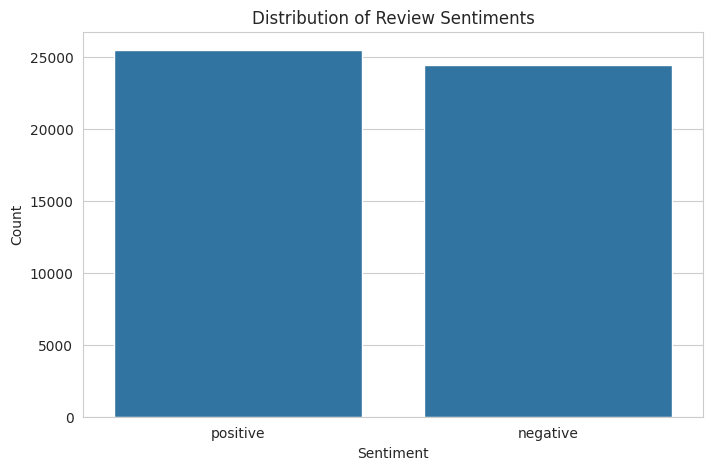

In [ ]:
# Visualize the distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment', data=train_df)
plt.title('Distribution of Review Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [ ]:
print("\n# 2. Text Preprocessing")

# Let's examine the reviews before preprocessing
print("Example review before preprocessing:")
print(train_df['content'].iloc[10])


# 2. Text Preprocessing
Example review before preprocessing:
A complete waste of time. Typographical errors, poor grammar, and a totally pathetic plot add up to absolutely nothing. I'm embarrassed for this author and very disappointed I actually paid for this book.


In [ ]:
def preprocess_text(text):
    """
    Function to preprocess text data:
    - Convert to lowercase
    - Remove special characters, numbers, and punctuation
    - Remove extra whitespace
    - Remove stopwords
    - Lemmatization
    """
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back into text
    processed_text = ' '.join(tokens)

    # Remove extra whitespace
    processed_text = re.sub(r'\s+', ' ', processed_text).strip()

    return processed_text

In [ ]:
train_df['content'].iloc[10]

"A complete waste of time. Typographical errors, poor grammar, and a totally pathetic plot add up to absolutely nothing. I'm embarrassed for this author and very disappointed I actually paid for this book."

In [ ]:
# Apply preprocessing to a sample for demonstration
sample_processed = preprocess_text(train_df['content'].iloc[10])
print("\nExample review after preprocessing:")
print(sample_processed)


Example review after preprocessing:
complete waste time typographical error poor grammar totally pathetic plot add absolutely nothing im embarrassed author disappointed actually paid book


In [ ]:
# For efficiency in this demonstration, let's process a subset of the data
print("\nApplying preprocessing to all reviews (this may take a moment)...")
start_time = time.time()

# Apply preprocessing to all reviews
train_df['processed_text'] = train_df['content'].apply(preprocess_text)
test_df['processed_text'] = test_df['content'].apply(preprocess_text)

print(f"Preprocessing completed in {time.time() - start_time:.2f} seconds")


Applying preprocessing to all reviews (this may take a moment)...
Preprocessing completed in 42.07 seconds


In [ ]:
# Check the processed data
print("\nSample processed reviews:")
display(train_df[['content', 'processed_text', 'sentiment']].head(3))


Sample processed reviews:


,content,processed_text,sentiment
0,This sound track was beautiful! It paints the senery in your mind so well I would recomend it ev...,sound track beautiful paint senery mind well would recomend even people hate vid game music play...,positive
1,I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I...,im reading lot review saying best game soundtrack figured id write review disagree bit opinino y...,positive
2,"This soundtrack is my favorite music of all time, hands down. The intense sadness of ""Prisoners ...",soundtrack favorite music time hand intense sadness prisoner fate mean youve played game hope di...,positive


## Exploratory Data Analysis

In [ ]:
# Review length analysis
train_df['review_length'] = train_df['content'].apply(len)
train_df['word_count'] = train_df['content'].apply(lambda x: len(x.split()))

print("\nReview length statistics:")
print(train_df['review_length'].describe())


Review length statistics:
count    50000.00000
mean       414.41414
std        237.36552
min         48.00000
25%        214.00000
50%        366.50000
75%        581.00000
max       1007.00000
Name: review_length, dtype: float64


In [ ]:
train_df.head()

,content,label,sentiment,processed_text,review_length,word_count
0,This sound track was beautiful! It paints the senery in your mind so well I would recomend it ev...,1,positive,sound track beautiful paint senery mind well would recomend even people hate vid game music play...,394,75
1,I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I...,1,positive,im reading lot review saying best game soundtrack figured id write review disagree bit opinino y...,470,91
2,"This soundtrack is my favorite music of all time, hands down. The intense sadness of ""Prisoners ...",1,positive,soundtrack favorite music time hand intense sadness prisoner fate mean youve played game hope di...,750,128
3,I truly like this soundtrack and I enjoy video game music. I have played this game and most of t...,1,positive,truly like soundtrack enjoy video game music played game music enjoy truly relaxing peacefulon d...,721,116
4,"If you've played the game, you know how divine the music is! Every single song tells a story of ...",1,positive,youve played game know divine music every single song tell story game good greatest song without...,425,77


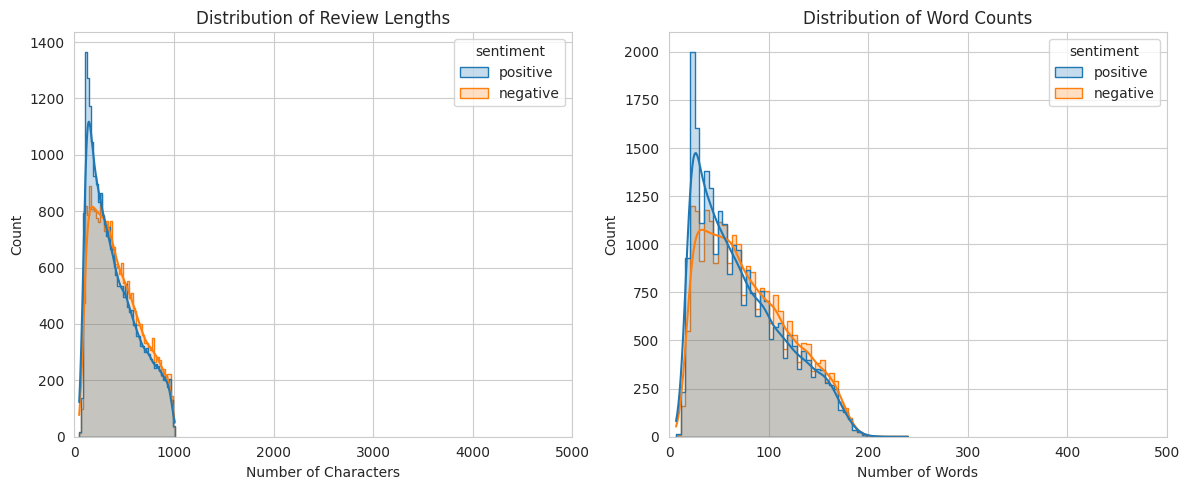

In [ ]:
# Visualize review length distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(data=train_df, x='review_length', hue='sentiment', bins=50, kde=True, element="step")
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Characters')
plt.xlim(0, 5000)  # Limiting x-axis for better visualization

plt.subplot(1, 2, 2)
sns.histplot(data=train_df, x='word_count', hue='sentiment', bins=50, kde=True, element="step")
plt.title('Distribution of Word Counts')
plt.xlabel('Number of Words')
plt.xlim(0, 500)  # Limiting x-axis for better visualization

plt.tight_layout()
plt.show()

### Word Clouds For Positive and negative Reviews

In [ ]:
# Word clouds for positive and negative reviews
def generate_wordcloud(text_series, title):
    text = ' '.join(text_series)
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=15)
    plt.show()

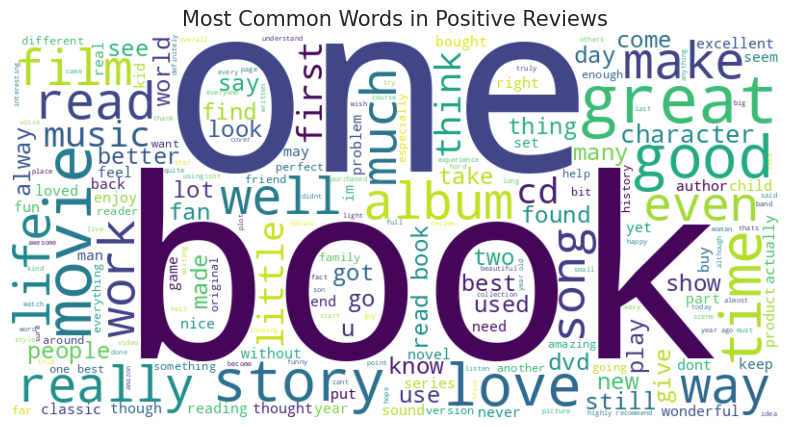

In [ ]:
# Positive reviews word cloud
positive_texts = train_df[train_df['sentiment'] == 'positive']['processed_text']
generate_wordcloud(positive_texts, 'Most Common Words in Positive Reviews')

In [ ]:
positive_texts

,processed_text
0,sound track beautiful paint senery mind well would recomend even people hate vid game music play...
1,im reading lot review saying best game soundtrack figured id write review disagree bit opinino y...
2,soundtrack favorite music time hand intense sadness prisoner fate mean youve played game hope di...
3,truly like soundtrack enjoy video game music played game music enjoy truly relaxing peacefulon d...
4,youve played game know divine music every single song tell story game good greatest song without...
...,...
49993,caliper work great love come hard case extra battery accurate much easier trying read standard c...
49994,work ok part feel loose slider mainly case easily broke fell three foot desk hinge broke first d...
49996,didnt expect much cheap got nice tool feel substantial work great nice case extra battery happy
49998,good price fast shipping could want serf purpose simple around houseshop measurement


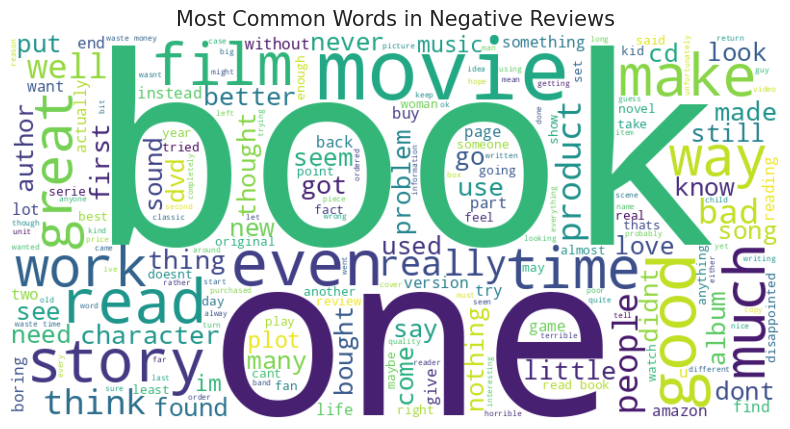

In [ ]:
# Negative reviews word cloud
negative_texts = train_df[train_df['sentiment'] == 'negative']['processed_text']
generate_wordcloud(negative_texts, 'Most Common Words in Negative Reviews')

In [ ]:
negative_texts

,processed_text
6,selfpublished book want know whyread paragraph star review must written m haddons family friends...
10,complete waste time typographical error poor grammar totally pathetic plot add absolutely nothin...
13,guess romance novel lover one discerning one others beware absolute drivel figured trouble typo ...
14,feel write keep others wasting money book seems written th grader poor grammatical skill age ano...
15,glaringly obvious glowing review written person perhaps author misspelling poor sentence structu...
...,...
49988,bought measure bicycle hub got conflicting reading supposed accurate well tape measure
49990,well cheap get pay surprise even used bought new set mitituyo cost alot needed job anyway
49991,caliper ordered supposed new unused item received nicked scratched even slightly bent whole unit...
49995,digital caliper suck first extend caliper extremely slow somewhat accurate skip give error like ...


# TF-IDF Vectorization and Modelling

In [ ]:
train_df.head()

,content,label,sentiment,processed_text,review_length,word_count
0,This sound track was beautiful! It paints the senery in your mind so well I would recomend it ev...,1,positive,sound track beautiful paint senery mind well would recomend even people hate vid game music play...,394,75
1,I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I...,1,positive,im reading lot review saying best game soundtrack figured id write review disagree bit opinino y...,470,91
2,"This soundtrack is my favorite music of all time, hands down. The intense sadness of ""Prisoners ...",1,positive,soundtrack favorite music time hand intense sadness prisoner fate mean youve played game hope di...,750,128
3,I truly like this soundtrack and I enjoy video game music. I have played this game and most of t...,1,positive,truly like soundtrack enjoy video game music played game music enjoy truly relaxing peacefulon d...,721,116
4,"If you've played the game, you know how divine the music is! Every single song tells a story of ...",1,positive,youve played game know divine music every single song tell story game good greatest song without...,425,77


In [ ]:
# Create feature matrix (X) and target variable (y)
X_train = train_df['processed_text']
y_train = train_df['label']  # Using numerical labels for modeling
X_test = test_df['processed_text']
y_test = test_df['label']

In [ ]:
# Create a pipeline with TF-IDF vectorization and Logistic Regression
print("\nBuilding TF-IDF and Logistic Regression pipeline...")

tfidf_lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, min_df=5, max_df=0.8)),
    ('classifier', LogisticRegression(C=1.0, solver='liblinear', max_iter=200))
])


Building TF-IDF and Logistic Regression pipeline...


In [ ]:
# Train the model
print("Training the model...")
start_time = time.time()
tfidf_lr_pipeline.fit(X_train, y_train)
print(f"Model training completed in {time.time() - start_time:.2f} seconds")

Training the model...
Model training completed in 3.76 seconds


# Model Evaluation

In [ ]:
y_pred = tfidf_lr_pipeline.predict(X_test)

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")


Accuracy: 0.8502


In [ ]:
# Display classification report
print("\nClassification Report:")
target_names = ['Negative', 'Positive']
print(classification_report(y_test, y_pred, target_names=target_names))


Classification Report:
              precision    recall  f1-score   support

    Negative       0.86      0.83      0.84      2435
    Positive       0.84      0.87      0.86      2565

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



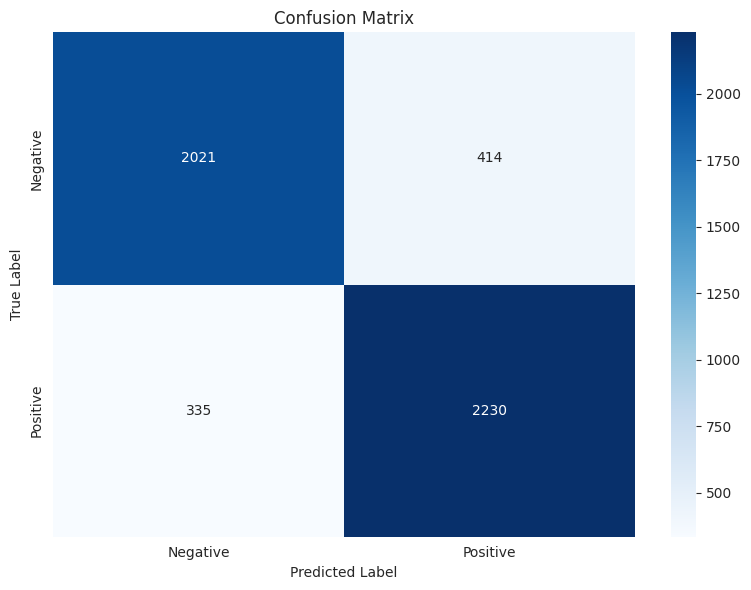

In [ ]:
# Create and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## Feature Importance Analysis

---



In [ ]:
# Get the TF-IDF vectorizer and logistic regression model from the pipeline
tfidf_vectorizer = tfidf_lr_pipeline.named_steps['tfidf']
lr_model = tfidf_lr_pipeline.named_steps['classifier']

In [ ]:
# Get feature names and coefficients
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = lr_model.coef_[0]

In [ ]:
print(feature_names)
print(coefficients)

['_the' 'aa' 'ab' ... 'zoom' 'zoot' 'zumo']
[-0.51326031 -0.38143062  0.20816216 ...  0.01073384 -0.09354004
  0.34963026]


In [ ]:
print(len(feature_names))
print(len(coefficients))

10000
10000


In [ ]:
# Create a dataframe to store feature importances
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

In [ ]:
# Display the most important features for positive sentiment
print("\nTop 15 features (words) indicating positive sentiment:")
display(feature_importance.head(15))


Top 15 features (words) indicating positive sentiment:


,Feature,Importance
3878,great,8.561498
3114,excellent,7.246432
5265,love,6.427642
6453,perfect,6.108706
3309,favorite,5.750304
824,best,5.611549
4152,highly,5.578049
638,awesome,5.574824
295,amazing,5.441947
2797,easy,5.223027


In [ ]:
# Display the most important features for negative sentiment
print("\nTop 15 features (words) indicating negative sentiment:")
display(feature_importance.tail(15).sort_values('Importance'))


Top 15 features (words) indicating negative sentiment:


,Feature,Importance
9676,waste,-8.991624
9894,worst,-8.721651
995,boring,-8.477985
6654,poor,-7.332196
2501,disappointed,-7.069423
4245,horrible,-6.579786
2503,disappointment,-6.363812
2502,disappointing,-5.854569
8902,terrible,-5.628669
6656,poorly,-5.455157


<ipython-input-49-2d65ad79787c>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15), palette='viridis')
<ipython-input-49-2d65ad79787c>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance.tail(15).sort_values('Importance'), palette='viridis')


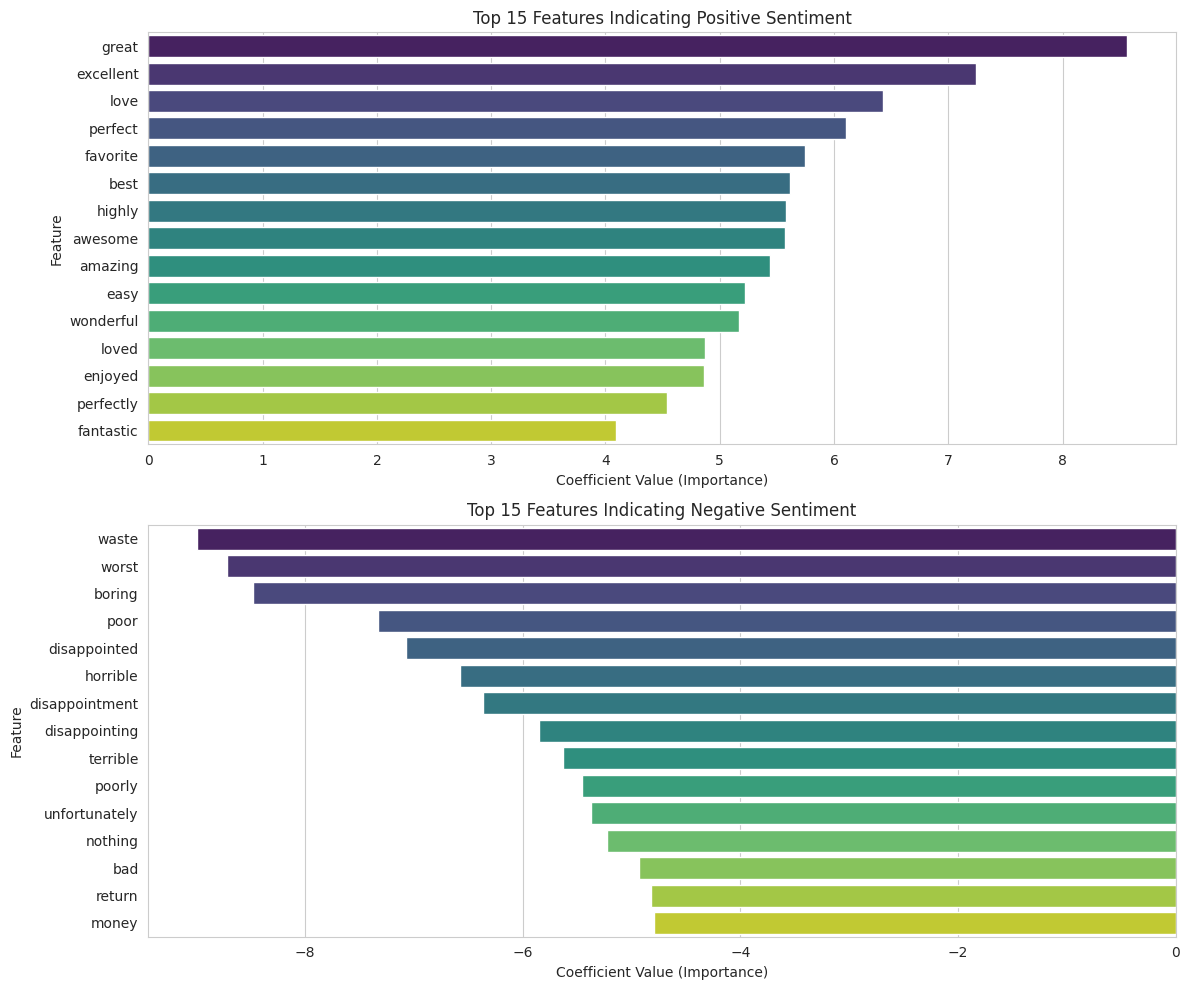

In [ ]:
# Visualize top features
plt.figure(figsize=(12, 10))

# Plot top positive features
plt.subplot(2, 1, 1)
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15), palette='viridis')
plt.title('Top 15 Features Indicating Positive Sentiment')
plt.xlabel('Coefficient Value (Importance)')

# Plot top negative features
plt.subplot(2, 1, 2)
sns.barplot(x='Importance', y='Feature', data=feature_importance.tail(15).sort_values('Importance'), palette='viridis')
plt.title('Top 15 Features Indicating Negative Sentiment')
plt.xlabel('Coefficient Value (Importance)')

plt.tight_layout()
plt.show()

## Testing with Custom Reviews

In [ ]:
def predict_sentiment(review_text, pipeline):
    """Function to predict sentiment for new reviews"""
    # Preprocess the text
    processed_text = preprocess_text(review_text)

    # Predict sentiment (0: negative, 1: positive)
    prediction = pipeline.predict([processed_text])[0]
    probability = pipeline.predict_proba([processed_text])[0]

    sentiment = 'Positive' if prediction == 1 else 'Negative'
    confidence = probability[prediction]

    return sentiment, confidence, processed_text

In [ ]:
# Test with some custom reviews
custom_reviews = [
    "This product is amazing! I love it so much and would definitely recommend it to anyone.",
    "The quality is terrible. It broke within a week and customer service was unhelpful.",
    "It's okay. Not great, not terrible. Does the job but could be better for the price.",
    "I have mixed feelings about this purchase. Some features are good but others need improvement."
]

In [ ]:
print("Predictions for custom reviews:")
for i, review in enumerate(custom_reviews):
    sentiment, confidence, processed_text = predict_sentiment(review, tfidf_lr_pipeline)
    print(f"\nReview {i+1}: {review}")
    print(f"Processed text: {processed_text}")
    print(f"Predicted sentiment: {sentiment} (confidence: {confidence:.4f})")

Predictions for custom reviews:

Review 1: This product is amazing! I love it so much and would definitely recommend it to anyone.
Processed text: product amazing love much would definitely recommend anyone
Predicted sentiment: Positive (confidence: 0.9970)

Review 2: The quality is terrible. It broke within a week and customer service was unhelpful.
Processed text: quality terrible broke within week customer service unhelpful
Predicted sentiment: Negative (confidence: 0.9652)

Review 3: It's okay. Not great, not terrible. Does the job but could be better for the price.
Processed text: okay great terrible job could better price
Predicted sentiment: Negative (confidence: 0.7877)

Review 4: I have mixed feelings about this purchase. Some features are good but others need improvement.
Processed text: mixed feeling purchase feature good others need improvement
Predicted sentiment: Positive (confidence: 0.7945)


## Model Performance Analysis

In [ ]:
# Get prediction probabilities for all test data
y_proba = tfidf_lr_pipeline.predict_proba(X_test)

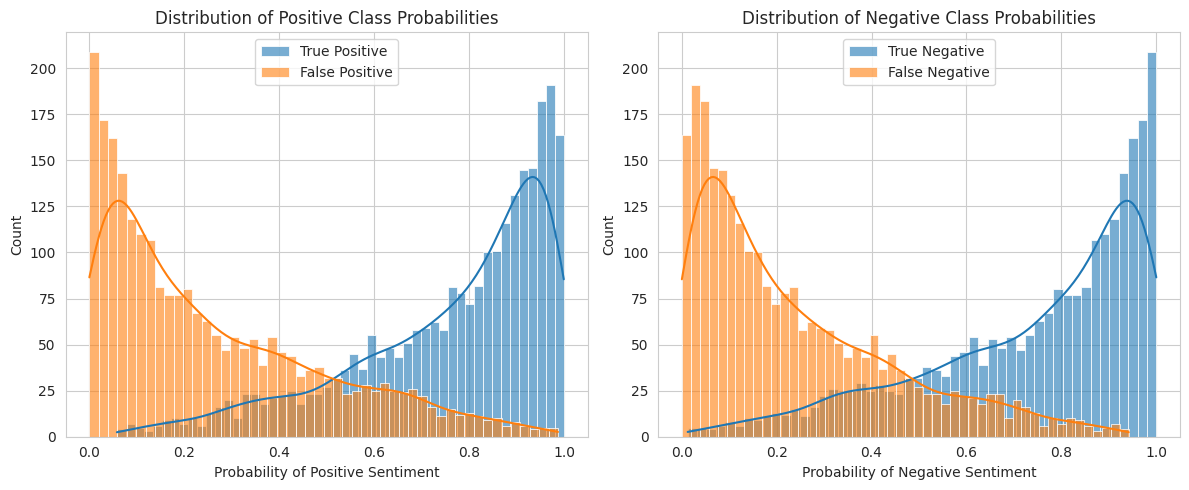

In [ ]:
# Plot probability distribution for each class
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(y_proba[:, 1][y_test == 1], bins=50, kde=True, label='True Positive', alpha=0.6)
sns.histplot(y_proba[:, 1][y_test == 0], bins=50, kde=True, label='False Positive', alpha=0.6)
plt.title('Distribution of Positive Class Probabilities')
plt.xlabel('Probability of Positive Sentiment')
plt.ylabel('Count')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(y_proba[:, 0][y_test == 0], bins=50, kde=True, label='True Negative', alpha=0.6)
sns.histplot(y_proba[:, 0][y_test == 1], bins=50, kde=True, label='False Negative', alpha=0.6)
plt.title('Distribution of Negative Class Probabilities')
plt.xlabel('Probability of Negative Sentiment')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()

## Conclusion

Key findings from this sentiment analysis project:

1. Model Performance:
   - The logistic regression model with TF-IDF vectorization achieved good accuracy on Amazon review sentiment classification.
   - Classification performance metrics show the model is effective at distinguishing between positive and negative reviews.

2. Feature Importance:
   - The model identified key words that strongly indicate positive or negative sentiment.
   - These words align with what we would intuitively expect in positive and negative product reviews.

3. Text Preprocessing:
   - Preprocessing steps like removing stopwords, lemmatization, and removing special characters
     helped improve the quality of the TF-IDF vectors.

4. Improvements and Future Work:
   - Try more advanced models like SVM, Random Forest, or Neural Networks
   - Experiment with n-grams in TF-IDF to capture phrases
   - Implement cross-validation for more robust evaluation
   - Try more advanced text embedding methods like Word2Vec or BERT
   - Add more features like review length, punctuation analysis, or emotion detection
   - Perform hyperparameter tuning to optimize model performance

This project demonstrates the effectiveness of TF-IDF vectorization combined with logistic regression
for sentiment analysis of product reviews.

Saving the Model

In [ ]:


# Save the model (uncomment to use)
import joblib
joblib.dump(tfidf_lr_pipeline, 'amazon_review_sentiment_model.pkl')
print("Model saved successfully!")



Model saved successfully!
